# 프로젝트 2 : 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?

In [1]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import datetime as dt

In [3]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso,RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error # for regression


## (1) 데이터 가져오기

In [4]:
## Local로 작업

In [5]:
train_df = pd.read_csv('./data/bike_train.csv')
test_df = pd.read_csv('./data/bike_test.csv')
df = train_df.copy()

In [6]:
df.shape

(10886, 12)

In [7]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [8]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


**Data Fields**. 
- datetime - hourly date + timestamp  
- season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- holiday - whether the day is considered a holiday
- workingday - whether the day is neither a weekend nor holiday
- weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
-           2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
-           3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
-           4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
- temp - temperature in Celsius
- atemp - "feels like" temperature in Celsius
- humidity - relative humidity
- windspeed - wind speed
- casual - number of non-registered user rentals initiated
- registered - number of registered user rentals initiated
- count - number of total rentals

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


### Null Value Check

In [10]:
df.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

<Axes: >

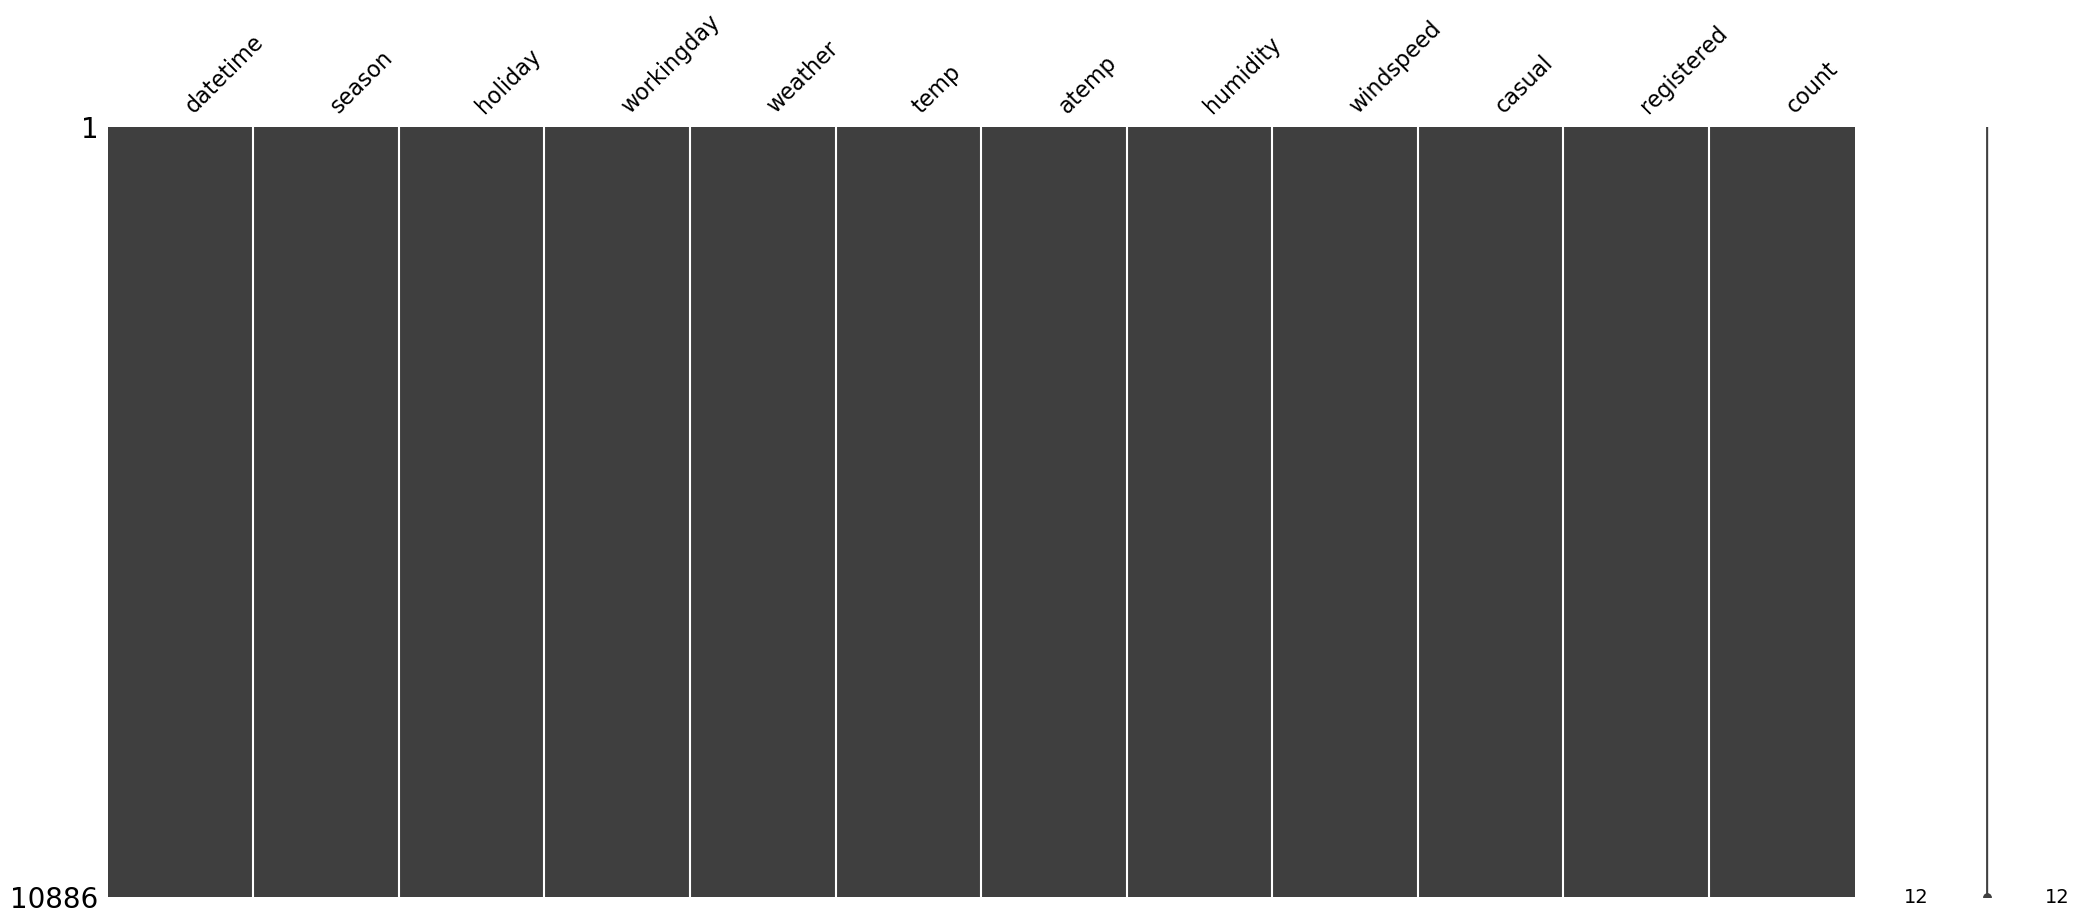

In [11]:
msno.matrix(df)

## (2) datetime 컬럼을 datetime 자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기

In [12]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [13]:
#weekday 도 중요 피쳐라 추가로 축출
datetime_col = ['year','month','day','weekday','hour','minute','second']

for col in datetime_col:
    df[col] = getattr(df['datetime'].dt, col)

## (3) year, month, day, hour, minute, second 데이터 개수 시각화하기

### Count_Plot

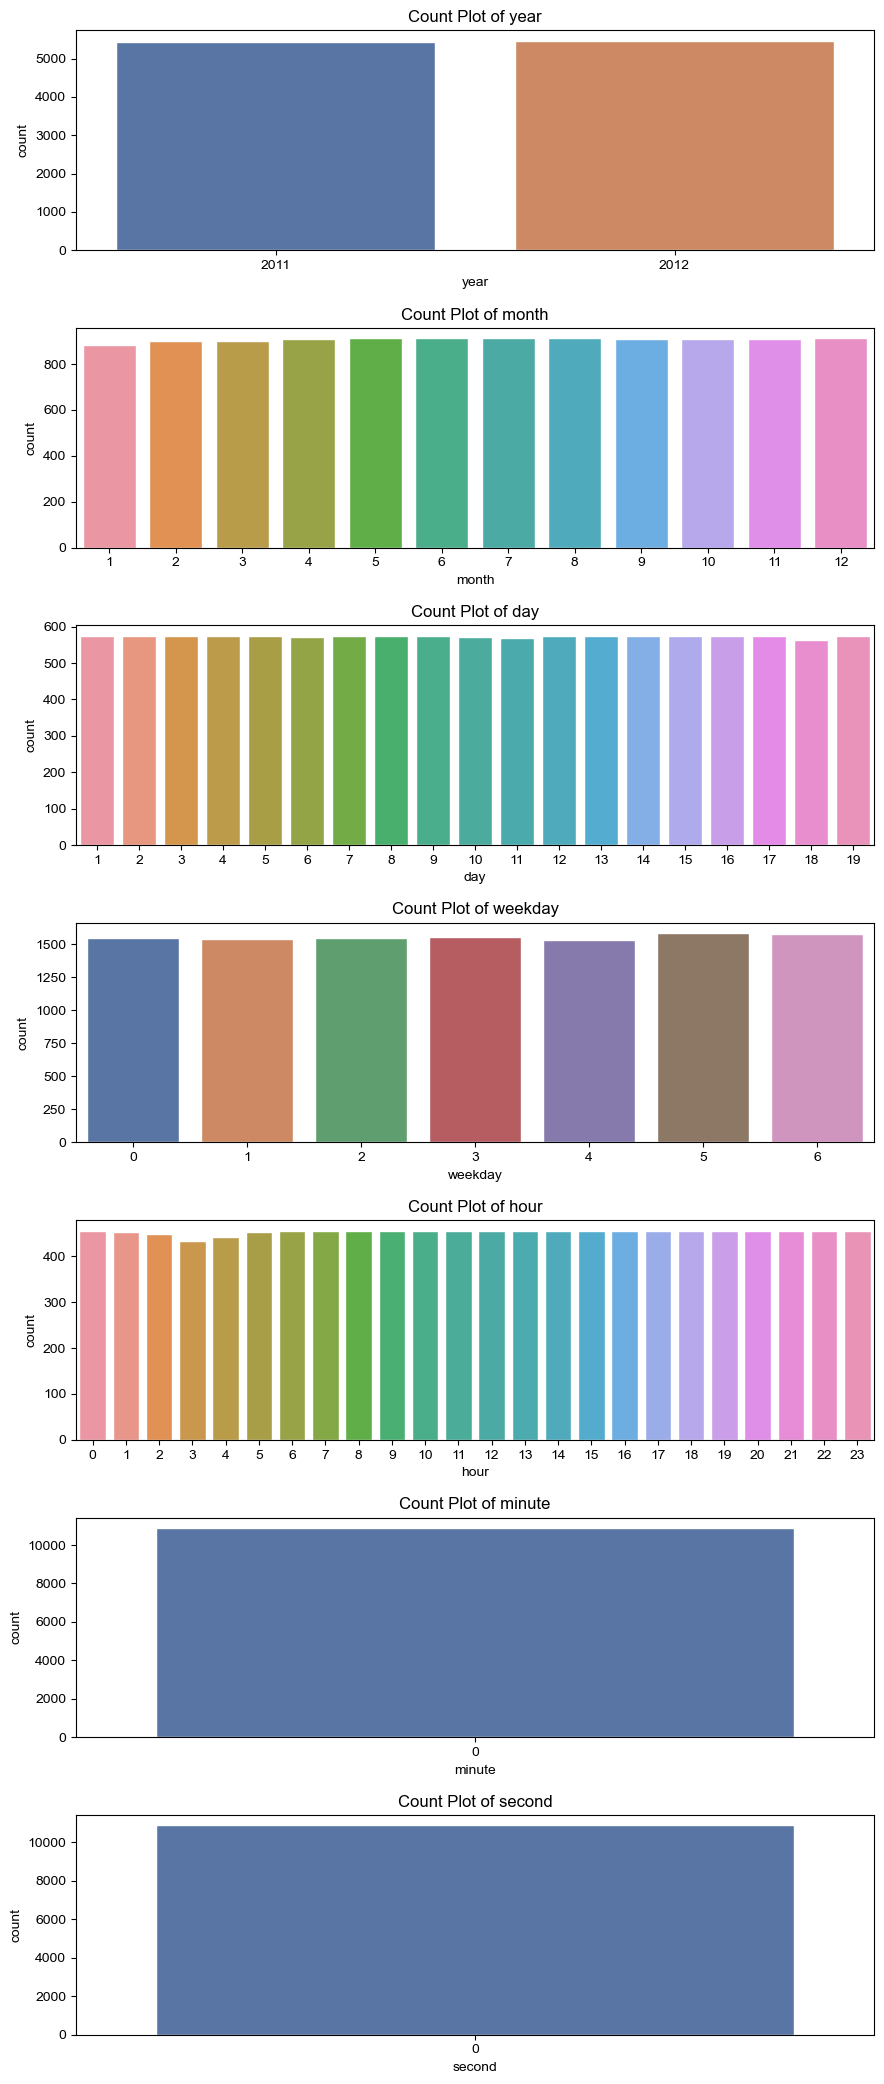

In [14]:
nrows, ncols = len(datetime_col), 1
fig, axs = plt.subplots(nrows,ncols,figsize=(9,3*nrows))
for i in range(len(datetime_col)):
    sns.set_theme(style="whitegrid")
    sns.countplot(x=df[datetime_col[i]],data=df, ax=axs[i])
    axs[i].set_title('Count Plot of {}'.format(datetime_col[i]))
plt.tight_layout()
plt.show()

### Bar_Plot

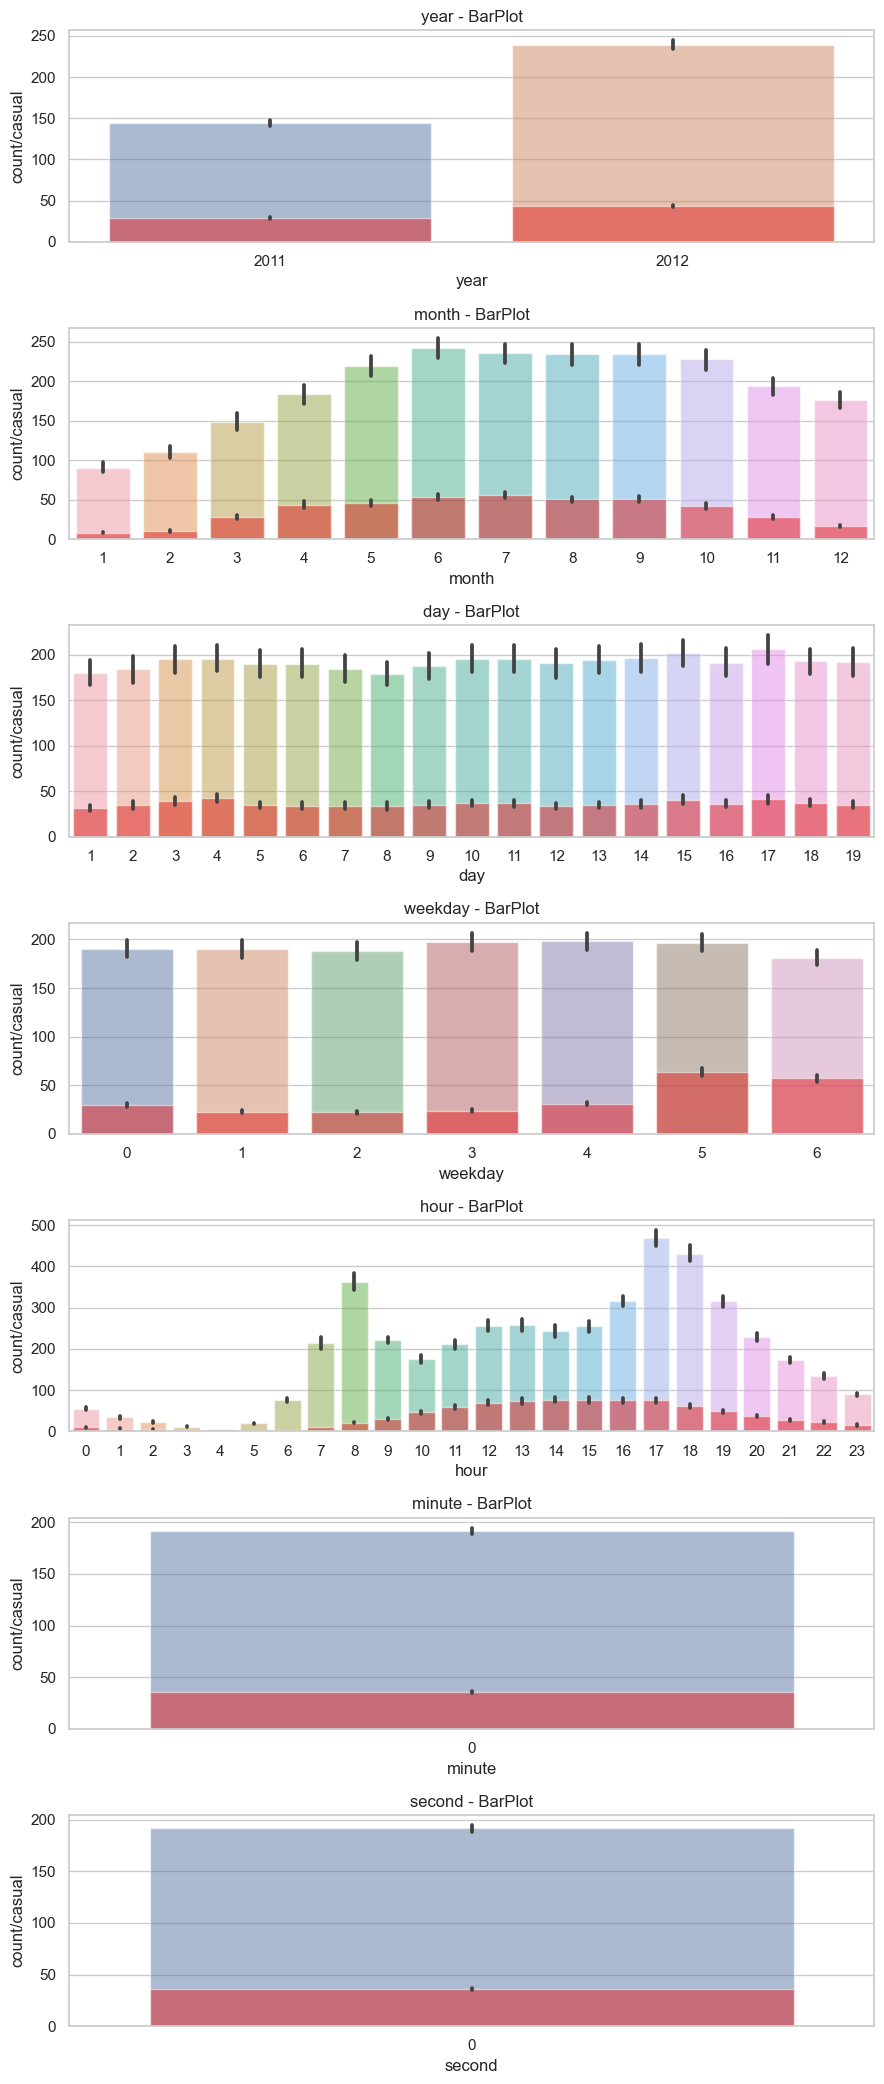

In [15]:
#counter plot 으로는 데이터 구분이 힘들어 bar_plot 으로 다시 그림, counter 와 다른 양상을 지닌, casual 도 같이 그림
fig, axs = plt.subplots(nrows,ncols,figsize=(9,3*nrows))
for i in range(len(datetime_col)):
    sns.barplot(data=df,x=datetime_col[i],y='count',ax=axs[i],alpha=0.5)
    sns.barplot(data=df,x=datetime_col[i],y='casual',ax=axs[i],alpha=0.5,color='red')
    axs[i].set_title('{} - BarPlot'.format(datetime_col[i]))
    axs[i].set_ylabel('count/casual')
plt.tight_layout()
plt.show()

## (4) X, y 컬럼 선택 및 train/test 데이터 분리

### Data Backfill - 결측치 채우기 

In [16]:
df['windspeed'].value_counts()

windspeed
0.0000     1313
8.9981     1120
11.0014    1057
12.9980    1042
7.0015     1034
15.0013     961
6.0032      872
16.9979     824
19.0012     676
19.9995     492
22.0028     372
23.9994     274
26.0027     235
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      58
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: count, dtype: int64

In [17]:
df['windspeed'] = df['windspeed'].replace(0,np.nan)
df['windspeed'].isnull().sum()

1313

In [18]:
df['windspeed'].fillna(method='bfill',inplace=True)
df['windspeed'].isnull().sum()
df['windspeed'].value_counts()

windspeed
7.0015     1374
8.9981     1332
6.0032     1310
11.0014    1176
12.9980    1127
15.0013     987
16.9979     872
19.0012     694
19.9995     507
22.0028     380
23.9994     276
26.0027     236
27.9993     187
30.0026     111
31.0009      89
32.9975      80
35.0008      59
39.0007      27
36.9974      22
43.0006      12
40.9973      11
43.9989       8
46.0022       3
56.9969       2
47.9988       2
51.9987       1
50.0021       1
Name: count, dtype: int64

### Outlier : IQR

<Axes: ylabel='count'>

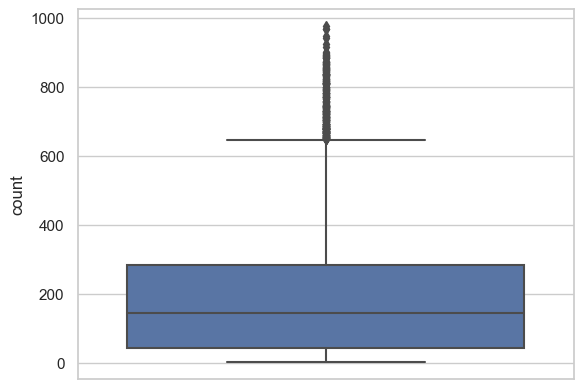

In [19]:
sns.boxplot(data=df,y='count')

<Axes: xlabel='hour', ylabel='count'>

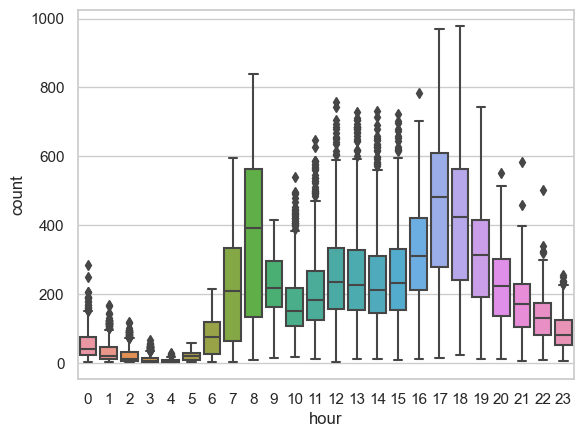

In [20]:
sns.boxplot(data=df,y='count',x='hour')

In [21]:
Q1 = df['count'].quantile(0.25)
Q3 = df['count'].quantile(0.75)

print(Q1,Q3)

IQR = Q3-Q1

42.0 284.0


In [22]:
IQR

242.0

In [23]:
filter = (df['count'] >= Q1 - 1.5 * IQR) & (df['count'] < Q3 + 1.5 *IQR )

In [24]:
display(df.loc[filter].shape)
display(df.shape)

(10583, 19)

(10886, 19)

In [25]:
df_clean = df.loc[filter]

In [26]:
df.loc[~filter]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour,minute,second
6611,2012-03-12 18:00:00,1,0,1,2,24.60,31.060,43,12.9980,89,623,712,2012,3,12,0,18,0,0
6634,2012-03-13 17:00:00,1,0,1,1,28.70,31.820,37,7.0015,62,614,676,2012,3,13,1,17,0,0
6635,2012-03-13 18:00:00,1,0,1,1,28.70,31.820,34,19.9995,96,638,734,2012,3,13,1,18,0,0
6649,2012-03-14 08:00:00,1,0,1,1,18.04,21.970,82,7.0015,34,628,662,2012,3,14,2,8,0,0
6658,2012-03-14 17:00:00,1,0,1,1,28.70,31.820,28,6.0032,140,642,782,2012,3,14,2,17,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10678,2012-12-11 08:00:00,4,0,1,2,13.94,15.150,61,19.9995,16,708,724,2012,12,11,1,8,0,0
10702,2012-12-12 08:00:00,4,0,1,2,10.66,12.880,65,11.0014,18,670,688,2012,12,12,2,8,0,0
10726,2012-12-13 08:00:00,4,0,1,1,9.84,11.365,60,12.9980,24,655,679,2012,12,13,3,8,0,0
10846,2012-12-18 08:00:00,4,0,1,1,15.58,19.695,94,6.0032,10,652,662,2012,12,18,1,8,0,0


In [27]:
df = df_clean.copy()

### Correlation 

In [28]:
clean_col = [ 'weather', 'temp', 'humidity', 'windspeed', 
              'year','season', 'month', 'weekday', 'holiday', 'workingday', 'hour',
              'casual', 'registered', 'count']

In [29]:
correlation = df[clean_col].corr()

<Axes: >

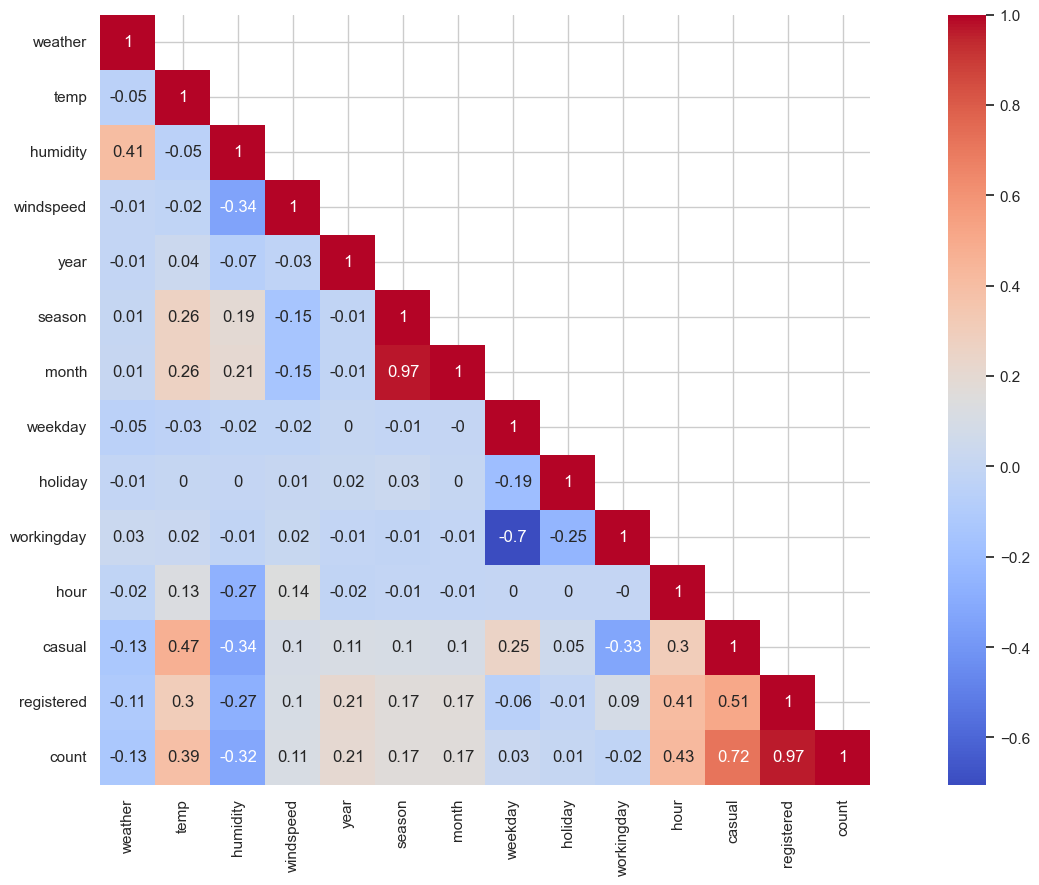

In [30]:
fig, ax = plt.subplots(figsize=(20,10))
mask = np.array(correlation)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(correlation,square=True,annot=np.round(correlation,2),mask=mask,cmap='coolwarm')

In [31]:
correlation.index.name = 'category'
correlation.T.index.name = 'relevant_category'

corr_df = pd.DataFrame(correlation.stack(),columns=['correaltion']).reset_index()

corr_df = corr_df.loc[corr_df['category'] != corr_df['relevant_category']]

corr_df['rank'] = corr_df.groupby('category')['correaltion'].rank('min',ascending=False).astype(int)

corr_df.sort_values('correaltion',ascending=False)

,category,relevant_category,correaltion,rank
76,season,month,0.971936,1
89,month,season,0.971936,1
181,registered,count,0.966296,1
194,count,registered,0.966296,1
193,count,casual,0.716661,2
...,...,...,...,...
156,casual,humidity,-0.335204,13
31,humidity,windspeed,-0.341241,13
44,windspeed,humidity,-0.341241,13
133,workingday,weekday,-0.704199,13


In [32]:
corr_df[corr_df['category']=='count'].sort_values('rank')

,category,relevant_category,correaltion,rank
194,count,registered,0.966296,1
193,count,casual,0.716661,2
192,count,hour,0.426164,3
183,count,temp,0.387816,4
186,count,year,0.205818,5
188,count,month,0.167439,6
187,count,season,0.165037,7
185,count,windspeed,0.113736,8
189,count,weekday,0.025890,9
190,count,holiday,0.007779,10


In [33]:
corr_df[corr_df['category']=='casual'].sort_values('rank')

,category,relevant_category,correaltion,rank
167,casual,count,0.716661,1
166,casual,registered,0.512966,2
155,casual,temp,0.468881,3
164,casual,hour,0.302234,4
161,casual,weekday,0.251154,5
158,casual,year,0.113232,6
159,casual,season,0.102565,7
157,casual,windspeed,0.098913,8
160,casual,month,0.095561,9
162,casual,holiday,0.053855,10


In [34]:
corr_df[corr_df['category']=='registered'].sort_values('rank')

,category,relevant_category,correaltion,rank
181,registered,count,0.966296,1
179,registered,casual,0.512966,2
178,registered,hour,0.412975,3
169,registered,temp,0.304261,4
172,registered,year,0.211531,5
174,registered,month,0.170815,6
173,registered,season,0.165274,7
171,registered,windspeed,0.103478,8
177,registered,workingday,0.090976,9
176,registered,holiday,-0.010304,10


### Min-Max Scaling : 수치형 자료 

In [35]:
score_cols = ['temp','humidity','windspeed']

In [36]:
df[score_cols]

,temp,humidity,windspeed
0,9.84,81,6.0032
1,9.02,80,6.0032
2,9.02,80,6.0032
3,9.84,75,6.0032
4,9.84,75,6.0032
...,...,...,...
10881,15.58,50,26.0027
10882,14.76,57,15.0013
10883,13.94,61,15.0013
10884,13.94,61,6.0032


In [37]:
def min_max_scaling(data):
    return (data - data.min()) / (data.max() - data.min())

In [38]:
df[score_cols] = df[score_cols].apply(min_max_scaling)

In [39]:
df[clean_col]

,weather,temp,humidity,windspeed,year,season,month,weekday,holiday,workingday,hour,casual,registered,count
0,1,0.224490,0.81,0.000000,2011,1,1,5,0,0,0,3,13,16
1,1,0.204082,0.80,0.000000,2011,1,1,5,0,0,1,8,32,40
2,1,0.204082,0.80,0.000000,2011,1,1,5,0,0,2,5,27,32
3,1,0.224490,0.75,0.000000,2011,1,1,5,0,0,3,3,10,13
4,1,0.224490,0.75,0.000000,2011,1,1,5,0,0,4,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,1,0.367347,0.50,0.392196,2012,4,12,2,0,1,19,7,329,336
10882,1,0.346939,0.57,0.176455,2012,4,12,2,0,1,20,10,231,241
10883,1,0.326531,0.61,0.176455,2012,4,12,2,0,1,21,4,164,168
10884,1,0.326531,0.61,0.000000,2012,4,12,2,0,1,22,12,117,129


### One-Hot Encoding : 범주형 자료 

In [40]:
category_col = ['weather', 'year', 'month', 'weekday', 'holiday', 'workingday', 'hour']

In [41]:
for col in category_col:
    df[col] = df[col].astype('category')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10583 entries, 0 to 10885
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10583 non-null  datetime64[ns]
 1   season      10583 non-null  int64         
 2   holiday     10583 non-null  category      
 3   workingday  10583 non-null  category      
 4   weather     10583 non-null  category      
 5   temp        10583 non-null  float64       
 6   atemp       10583 non-null  float64       
 7   humidity    10583 non-null  float64       
 8   windspeed   10583 non-null  float64       
 9   casual      10583 non-null  int64         
 10  registered  10583 non-null  int64         
 11  count       10583 non-null  int64         
 12  year        10583 non-null  category      
 13  month       10583 non-null  category      
 14  day         10583 non-null  int32         
 15  weekday     10583 non-null  category      
 16  hour        10583 non-null 

In [43]:
weather_df = pd.get_dummies(df['weather'],prefix='weather')

In [44]:
df=pd.concat([df,weather_df],axis=1)

In [45]:
season_df = pd.get_dummies(df['season'],prefix='season')

In [46]:
df=pd.concat([df,season_df],axis=1)

In [47]:
df['year'] = df.loc[:,'year'] == 2011

### Feature Selection 

In [48]:
df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count',
       'year', 'month', 'day', 'weekday', 'hour', 'minute', 'second',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1',
       'season_2', 'season_3', 'season_4'],
      dtype='object')

#### 1차 Feature Selection : count, registered, casual 모두에게 영향을 미치지 않는 col : day, second 등

In [49]:
clean_col = [ 'holiday', 'workingday', 'temp',
       'humidity', 'windspeed', 'count',
       'year', 'month', 'weekday', 'hour',
       'weather_1', 'weather_2', 'weather_3', 'weather_4', 'season_1',
       'season_2', 'season_3', 'season_4']

In [50]:
df[clean_col]

,holiday,workingday,temp,humidity,windspeed,count,year,month,weekday,hour,weather_1,weather_2,weather_3,weather_4,season_1,season_2,season_3,season_4
0,0,0,0.224490,0.81,0.000000,16,True,1,5,0,True,False,False,False,True,False,False,False
1,0,0,0.204082,0.80,0.000000,40,True,1,5,1,True,False,False,False,True,False,False,False
2,0,0,0.204082,0.80,0.000000,32,True,1,5,2,True,False,False,False,True,False,False,False
3,0,0,0.224490,0.75,0.000000,13,True,1,5,3,True,False,False,False,True,False,False,False
4,0,0,0.224490,0.75,0.000000,1,True,1,5,4,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,0,1,0.367347,0.50,0.392196,336,False,12,2,19,True,False,False,False,False,False,False,True
10882,0,1,0.346939,0.57,0.176455,241,False,12,2,20,True,False,False,False,False,False,False,True
10883,0,1,0.326531,0.61,0.176455,168,False,12,2,21,True,False,False,False,False,False,False,True
10884,0,1,0.326531,0.61,0.000000,129,False,12,2,22,True,False,False,False,False,False,False,True


## (5) LinearRegression 모델 학습 : Count Predict -> Casual + Registered Predic Model 로 전환

#### Train-Test Set 

In [51]:
X = df[clean_col].drop(['count'],axis=1)

In [52]:
y = df[['casual','registered']]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=36)

In [54]:
y_train

,casual,registered
7397,59,180
10457,4,21
2943,22,119
10833,7,333
7825,55,148
...,...,...
9716,0,19
7380,55,148
2984,18,103
9326,18,91


In [55]:
y_test['casual']

1805       9
9689       3
435        0
9858       2
624        0
        ... 
8651      51
2220      35
9782      10
9481      30
10063    119
Name: casual, Length: 2117, dtype: int64

In [56]:
y_test['registered']

1805       7
9689      12
435        3
9858       2
624        7
        ... 
8651     376
2220      95
9782     176
9481     130
10063    316
Name: registered, Length: 2117, dtype: int64

### Casual Predict

#### PCA

In [57]:
'''from sklearn.decomposition import PCA

#Train data에 PCA 알고리즘 적용
train_X_ = StandardScaler().fit_transform(X_train) # 불러온 데이터에 대한 정규화 -> 각 column의 range of value가 전부 다르기 때문에 정규화를 진행해 주어야 합니다.
train_df = pd.DataFrame(train_X_)
pca = PCA(n_components=2) # 주성분의 수를 2개, 즉 기저가 되는 방향벡터를 2개로 하는 PCA 알고리즘 수행
pc = pca.fit_transform(train_df)

test_X_ = StandardScaler().fit_transform(X_test) # normalization
test_df = pd.DataFrame(test_X_)
pca_test = PCA(n_components=2)
pc_test = pca_test.fit_transform(test_df)'''

'from sklearn.decomposition import PCA\n\n#Train data에 PCA 알고리즘 적용\ntrain_X_ = StandardScaler().fit_transform(X_train) # 불러온 데이터에 대한 정규화 -> 각 column의 range of value가 전부 다르기 때문에 정규화를 진행해 주어야 합니다.\ntrain_df = pd.DataFrame(train_X_)\npca = PCA(n_components=2) # 주성분의 수를 2개, 즉 기저가 되는 방향벡터를 2개로 하는 PCA 알고리즘 수행\npc = pca.fit_transform(train_df)\n\ntest_X_ = StandardScaler().fit_transform(X_test) # normalization\ntest_df = pd.DataFrame(test_X_)\npca_test = PCA(n_components=2)\npc_test = pca_test.fit_transform(test_df)'

#### LinearRegression 모델 학습 - Casual

In [58]:
model = LinearRegression()

In [59]:
model.fit(X_train,y_train['casual'])

LinearRegression()

In [60]:
y_pred_casual = model.predict(X_test)

In [61]:
print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)

Coefficients:  [-8.70272068e+00 -3.32224727e+01  1.18576661e+02 -6.82787241e+01
 -4.17480937e-02 -7.15550709e+00 -3.26904568e-01  6.05045552e-01
  1.07392824e+00 -1.27726395e+00  2.15022364e+00 -8.72959685e-01
  1.42108547e-14 -2.88261034e+00  2.50941008e+00 -7.47635414e+00
  7.84955440e+00]
Intercept:  34.371064735054276


### Registered Predict

#### PCA -rollback

In [62]:
'''#Train data에 PCA 알고리즘 적용
train_X_ = StandardScaler().fit_transform(X_train) # 불러온 데이터에 대한 정규화 -> 각 column의 range of value가 전부 다르기 때문에 정규화를 진행해 주어야 합니다.
train_df = pd.DataFrame(train_X_)
pca = PCA(n_components=2) # 주성분의 수를 2개, 즉 기저가 되는 방향벡터를 2개로 하는 PCA 알고리즘 수행
pc = pca.fit_transform(train_df)

test_X_ = StandardScaler().fit_transform(X_test) # normalization
test_df = pd.DataFrame(test_X_)
pca_test = PCA(n_components=2)
pc_test = pca_test.fit_transform(test_df)'''

'#Train data에 PCA 알고리즘 적용\ntrain_X_ = StandardScaler().fit_transform(X_train) # 불러온 데이터에 대한 정규화 -> 각 column의 range of value가 전부 다르기 때문에 정규화를 진행해 주어야 합니다.\ntrain_df = pd.DataFrame(train_X_)\npca = PCA(n_components=2) # 주성분의 수를 2개, 즉 기저가 되는 방향벡터를 2개로 하는 PCA 알고리즘 수행\npc = pca.fit_transform(train_df)\n\ntest_X_ = StandardScaler().fit_transform(X_test) # normalization\ntest_df = pd.DataFrame(test_X_)\npca_test = PCA(n_components=2)\npc_test = pca_test.fit_transform(test_df)'

#### LinearRegression 모델 학습 - Registered

In [63]:
model = LinearRegression()

In [64]:
model.fit(X_train,y_train['registered'])

LinearRegression()

In [65]:
y_pred_registered = model.predict(X_test)

In [66]:
print("Coefficients: ", model.coef_)
print("Intercept: ", model.intercept_)

Coefficients:  [   8.47285594   27.78310848  174.05054795 -106.34604919   24.38354865
  -51.6845711     7.32852375    1.21113558    6.05095044    8.33131488
   12.2239652   -20.55528008    0.           12.02825513    8.18223887
  -23.98751411    3.77702011]
Intercept:  0.4952053154358964


### Count = Casual + Predict

In [67]:
y_pred_count = y_pred_casual + y_pred_registered #count 예측 값 합

In [68]:
y_test_count = y_test['casual'] + y_test['registered'] 

In [69]:
y_test

,casual,registered
1805,9,7
9689,3,12
435,0,3
9858,2,2
624,0,7
...,...,...
8651,51,376
2220,35,95
9782,10,176
9481,30,130


In [70]:
y_test_count

1805      16
9689      15
435        3
9858       4
624        7
        ... 
8651     427
2220     130
9782     186
9481     160
10063    435
Length: 2117, dtype: int64

## (6) 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산

In [72]:
print("MSE: ", mean_squared_error(y_test_count, y_pred_count))
print("RMSE: ",np.sqrt(mean_squared_error(y_test_count, y_pred_count)))

MSE:  14700.008114871935
RMSE:  121.24358999498462


# 현재 RMSE : 121

1차 시도 (baseline) :
    - MSE:  20476
    - RMSE:  143

2차 시도 (min-max Scaling) : 143->122
    - MSE:  14972
    - RMSE: 122

In [ ]:
3차 시도 (astype-Category) : 큰 변화 없음
    - MSE:  14972
    - RMSE: 122

4차 시도 (Casual + Registered) : 122->115 감소
    - MSE:  13225
    - RMSE: 115

4차 시도 (Casual + Registered) : 122->115 감소
    - MSE:  13225
    - RMSE: 115

In [ ]:
5차 시도 (One-hot Encoding) : 살짝 내려갔음 
    - MSE:  13080
    - RMSE:  114

In [ ]:
6차 시도 (PCA 적용) : 오히려 증가  : Rollback
    - MSE:  16260
    - RMSE:  127

## (7) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기

In [73]:
sns.scatterplot(x=X_test['temp'],y=y_pred_count)

NameError: name 'y_pred' is not defined

In [ ]:
sns.scatterplot(x=X_test['humidity'],y=y_pred)